In [1]:
import numpy as np
import xarray as xr

In [2]:
ds_u = xr.open_dataset("./data/era5_2017_2021_u10n_0.25deg.nc")
ds_v = xr.open_dataset("./data/era5_2017_2021_v10n_0.25deg.nc")
ds_swh = xr.open_dataset("./data/era5_2017_2021_shww_0.50deg.nc")

C:\Users\user\AppData\Local\Temp\ipykernel_2272\811111846.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_u = xr.open_dataset("./data/era5_2017_2021_u10n_0.25deg.nc")
C:\Users\user\AppData\Local\Temp\ipykernel_2272\811111846.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_v = xr.open_dataset("./data/era5_2017_2021_v10n_0.25deg.nc")
C:\Users\user\AppData\Local\Temp\ipykernel_2272\811111846.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_swh = xr.open_dataset("./data/era5_2017_2021_shww_0.50deg.nc")


In [ ]:
ds_u_subset = ds_u.sel(
    latitude=slice(42.0, 32.25),
    longitude=slice(-68.0, -58.25)
)
ds_v_subset = ds_v.sel(
    latitude=slice(42.0, 32.25),
    longitude=slice(-68.0, -58.25)
)
print("UV dims:", ds_u.dims, ds_v.dims)
print("UV subset dims:", ds_u_subset.dims, ds_v_subset.dims)

UV dims: FrozenMappingWarningOnValuesAccess({'time': 43824, 'latitude': 41, 'longitude': 41}) FrozenMappingWarningOnValuesAccess({'time': 43824, 'latitude': 41, 'longitude': 41})
UV subset dims: FrozenMappingWarningOnValuesAccess({'time': 43824, 'latitude': 40, 'longitude': 40}) <xarray.Dataset> Size: 281MB
Dimensions:     (time: 43824, latitude: 40, longitude: 40)
Coordinates:
  * time        (time) datetime64[ns] 351kB 2017-01-01 ... 2021-12-31T23:00:00
    valid_time  (time) datetime64[ns] 351kB ...
  * latitude    (latitude) float64 320B 42.0 41.75 41.5 ... 32.75 32.5 32.25
  * longitude   (longitude) float64 320B -68.0 -67.75 -67.5 ... -58.5 -58.25
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
Data variables:
    v10n        (time, latitude, longitude) float32 280MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    

In [4]:
print("SWH dims:", ds_swh.dims)

SWH dims: FrozenMappingWarningOnValuesAccess({'time': 43824, 'latitude': 21, 'longitude': 21})


In [5]:
# Interpolation for SWH
swh = ds_swh["shww"]

lat_all_41 = np.linspace(42.0, 32.0, 41)    # [42.00, 41.75, 41.50, …, 32.00]
lon_all_41 = np.linspace(-68.0, -58.0, 41)  # [-68.00, -67.75, …, -58.00]

lat_target = xr.DataArray(lat_all_41[:-1], dims="latitude")   # 42.00 → 32.25
lon_target = xr.DataArray(lon_all_41[:-1], dims="longitude")  # -68.00 → -58.25

swh_interp = swh.interp(
    latitude = lat_target,
    longitude = lon_target,
    method = "cubic"
)

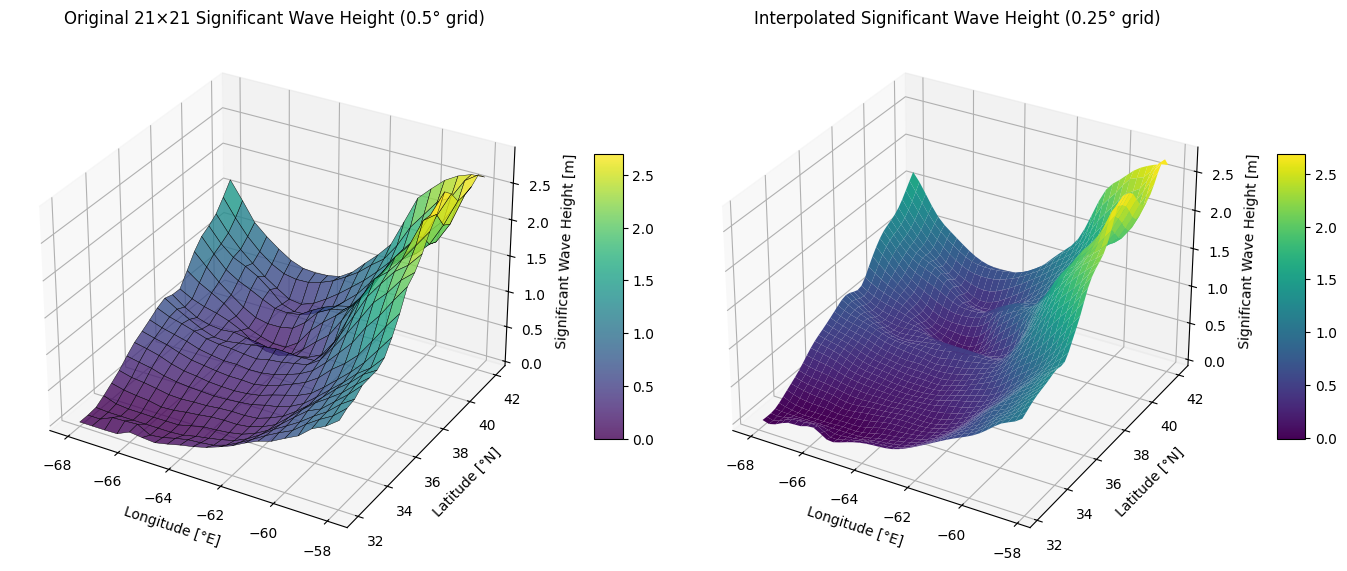

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

t0_coarse = swh.isel(time=0)
t0_interp = swh_interp.isel(time=0)

lats_coarse = t0_coarse.latitude.values    # (21,)
lons_coarse = t0_coarse.longitude.values   # (21,)
Z_coarse = t0_coarse.values                 # (21, 21)
if lats_coarse[0] > lats_coarse[-1]:
    lats_coarse = lats_coarse[::-1]
    Z_coarse    = Z_coarse[::-1, :]

Lon_c, Lat_c = np.meshgrid(lons_coarse, lats_coarse)

lats_40 = t0_interp.latitude.values     # (40,)
lons_40 = t0_interp.longitude.values    # (40,)
Z_40 = t0_interp.values                 # (40, 40)

Lon_f, Lat_f = np.meshgrid(lons_40, lats_40)

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
surf1 = ax1.plot_surface(
    Lon_c, Lat_c, Z_coarse,
    cmap="viridis", edgecolor="k", linewidth=0.3, alpha=0.8
)
ax1.set_title("Original 21×21 Significant Wave Height (0.5° grid)")
ax1.set_xlabel("Longitude [°E]")
ax1.set_ylabel("Latitude [°N]")
ax1.set_zlabel("Significant Wave Height [m]")
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, pad=0.08)

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
surf2 = ax2.plot_surface(
    Lon_f, Lat_f, Z_40,
    cmap="viridis", linewidth=0, antialiased=True
)
ax2.set_title("Interpolated Significant Wave Height (0.25° grid)")
ax2.set_xlabel("Longitude [°E]")
ax2.set_ylabel("Latitude [°N]")
ax2.set_zlabel("Significant Wave Height [m]")
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10, pad=0.08)

plt.tight_layout()
plt.show()

In [7]:
print(swh_interp)

<xarray.DataArray 'shww' (time: 43824, latitude: 40, longitude: 40)> Size: 561MB
array([[[ 1.66162312e+00,  1.54949408e+00,  1.41063912e+00, ...,
          2.59174357e+00,  2.61987400e+00,  2.63463894e+00],
        [ 1.58031003e+00,  1.45623577e+00,  1.32698268e+00, ...,
          2.54252524e+00,  2.66109283e+00,  2.74386849e+00],
        [ 1.49341732e+00,  1.36727592e+00,  1.24558310e+00, ...,
          2.46644448e+00,  2.61834963e+00,  2.73220990e+00],
        ...,
        [ 2.92699988e-05, -1.22084548e-02,  1.66400247e-04, ...,
          1.02261792e+00,  1.09450647e+00,  1.16526248e+00],
        [-8.99700293e-06, -2.40473206e-02,  5.57992974e-06, ...,
          1.00870340e+00,  1.06268595e+00,  1.13001398e+00],
        [ 3.00715116e-03, -2.35144684e-02, -1.56359932e-04, ...,
          9.95933044e-01,  1.03541667e+00,  1.09662811e+00]],

       [[ 1.91919100e+00,  1.80680818e+00,  1.70898463e+00, ...,
          2.12790252e+00,  2.16114012e+00,  2.18174083e+00],
        [ 1.82543591e+

In [8]:
print(ds_u_subset["u10n"])

<xarray.DataArray 'u10n' (time: 43824, latitude: 40, longitude: 40)> Size: 280MB
[70118400 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 351kB 2017-01-01 ... 2021-12-31T23:00:00
    valid_time  (time) datetime64[ns] 351kB ...
  * latitude    (latitude) float64 320B 42.0 41.75 41.5 ... 32.75 32.5 32.25
  * longitude   (longitude) float64 320B -68.0 -67.75 -67.5 ... -58.5 -58.25
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
Attributes: (12/31)
    GRIB_paramId:                             228131
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1681
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           u10n
    GRIB_totalNumber:                         0
    GRIB_un

In [9]:
print(ds_v_subset["v10n"])

<xarray.DataArray 'v10n' (time: 43824, latitude: 40, longitude: 40)> Size: 280MB
[70118400 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 351kB 2017-01-01 ... 2021-12-31T23:00:00
    valid_time  (time) datetime64[ns] 351kB ...
  * latitude    (latitude) float64 320B 42.0 41.75 41.5 ... 32.75 32.5 32.25
  * longitude   (longitude) float64 320B -68.0 -67.75 -67.5 ... -58.5 -58.25
    number      int32 4B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
Attributes: (12/31)
    GRIB_paramId:                             228132
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1681
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           v10n
    GRIB_totalNumber:                         0
    GRIB_un

In [12]:
import pickle
import os

u10n_arr     = np.array(ds_u_subset["u10n"].values)        # shape: (ntime, 40, 40)
v10n_arr     = np.array(ds_v_subset["v10n"].values)        # shape: (ntime, 40, 40)
swh_interp_arr = np.array(swh_interp.values)               # shape: (ntime, 40, 40)

lat_arr = np.array(ds_u_subset["latitude"].values)         # shape: (40,)
lon_arr = np.array(ds_u_subset["longitude"].values)        # shape: (40,)
time_arr = np.array(ds_u_subset["time"].values)            # shape: (ntime,)

out_dir = "./data"
os.makedirs(out_dir, exist_ok=True)

# 2) Save with np.save (this will append “.npy” automatically):
np.save(os.path.join(out_dir, "u10n_array.npy"), u10n_arr)
np.save(os.path.join(out_dir, "v10n_array.npy"), v10n_arr)
np.save(os.path.join(out_dir, "swh_interp_array.npy"), swh_interp_arr)

# 3) (Optional) Save coordinate arrays too:
np.save(os.path.join(out_dir, "latitudes.npy"), lat_arr)
np.save(os.path.join(out_dir, "longitudes.npy"), lon_arr)
np.save(os.path.join(out_dir, "times.npy"), time_arr)

In [14]:
print(u10n_arr)
print(u10n_arr.shape)

[[[ 5.18225098e+00  5.04650879e+00  4.91955566e+00 ...  1.09635010e+01
    1.10289307e+01  1.10523682e+01]
  [ 5.05920410e+00  4.99865723e+00  4.93127441e+00 ...  1.07174072e+01
    1.08267822e+01  1.09468994e+01]
  [ 4.88928223e+00  4.88439941e+00  4.93811035e+00 ...  1.04918213e+01
    1.06265869e+01  1.08560791e+01]
  ...
  [ 1.22912598e+00  1.07385254e+00  8.68774414e-01 ...  1.42639160e+00
    1.64416504e+00  1.80041504e+00]
  [ 7.65258789e-01  6.42211914e-01  5.19165039e-01 ...  1.08166504e+00
    1.29260254e+00  1.48986816e+00]
  [ 1.16821289e-01 -1.54663086e-01 -4.78881836e-01 ...  7.07641602e-01
    9.34204102e-01  1.18322754e+00]]

 [[ 5.51164246e+00  5.17375183e+00  4.99015808e+00 ...  1.03046112e+01
    1.03026581e+01  1.02831268e+01]
  [ 5.29972839e+00  5.06144714e+00  4.92668152e+00 ...  1.01200409e+01
    1.01717987e+01  1.02069550e+01]
  [ 5.21672058e+00  4.96379089e+00  4.92082214e+00 ...  9.97355652e+00
    1.00331268e+01  1.01171112e+01]
  ...
  [ 1.03703308e+00  8.8

In [15]:
print(v10n_arr)
print(v10n_arr.shape)

[[[ 1.06271057e+01  1.05304260e+01  1.03927307e+01 ... -4.11605835e+00
   -4.20004272e+00 -4.41976929e+00]
  [ 1.03458557e+01  1.02130432e+01  9.97964478e+00 ... -4.33676147e+00
   -4.49008179e+00 -4.78402710e+00]
  [ 9.97866821e+00  9.76577759e+00  9.50894165e+00 ... -4.64144897e+00
   -4.88265991e+00 -5.27133179e+00]
  ...
  [ 1.47378540e+00  9.86480713e-01  4.91363525e-01 ... -8.28012085e+00
   -8.38558960e+00 -8.51156616e+00]
  [ 1.26187134e+00  7.50152588e-01  7.96508789e-03 ... -8.33285522e+00
   -8.43051147e+00 -8.55844116e+00]
  [ 1.04898071e+00  6.14410400e-01 -8.87145996e-02 ... -8.35336304e+00
   -8.46371460e+00 -8.57699585e+00]]

 [[ 1.09035797e+01  1.07492828e+01  1.07014313e+01 ... -3.70481873e+00
   -3.80540466e+00 -3.88645935e+00]
  [ 1.07385406e+01  1.06057281e+01  1.04319000e+01 ... -3.86106873e+00
   -3.93235779e+00 -4.01438904e+00]
  [ 1.05363922e+01  1.03195953e+01  1.01115875e+01 ... -4.04075623e+00
   -4.12962341e+00 -4.26927185e+00]
  ...
  [ 2.02662659e+00  1.7

In [16]:
print(swh_interp_arr)
print(swh_interp_arr.shape)

[[[ 1.66162312e+00  1.54949408e+00  1.41063912e+00 ...  2.59174357e+00
    2.61987400e+00  2.63463894e+00]
  [ 1.58031003e+00  1.45623577e+00  1.32698268e+00 ...  2.54252524e+00
    2.66109283e+00  2.74386849e+00]
  [ 1.49341732e+00  1.36727592e+00  1.24558310e+00 ...  2.46644448e+00
    2.61834963e+00  2.73220990e+00]
  ...
  [ 2.92699988e-05 -1.22084548e-02  1.66400247e-04 ...  1.02261792e+00
    1.09450647e+00  1.16526248e+00]
  [-8.99700293e-06 -2.40473206e-02  5.57992974e-06 ...  1.00870340e+00
    1.06268595e+00  1.13001398e+00]
  [ 3.00715116e-03 -2.35144684e-02 -1.56359932e-04 ...  9.95933044e-01
    1.03541667e+00  1.09662811e+00]]

 [[ 1.91919100e+00  1.80680818e+00  1.70898463e+00 ...  2.12790252e+00
    2.16114012e+00  2.18174083e+00]
  [ 1.82543591e+00  1.71181358e+00  1.61167176e+00 ...  2.04534312e+00
    2.08341997e+00  2.13477115e+00]
  [ 1.75879629e+00  1.64561290e+00  1.53955856e+00 ...  1.95396076e+00
    2.00949586e+00  2.08115731e+00]
  ...
  [-7.88910751e-04 -5.7